In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 22.5 MB 1.3 MB/s 


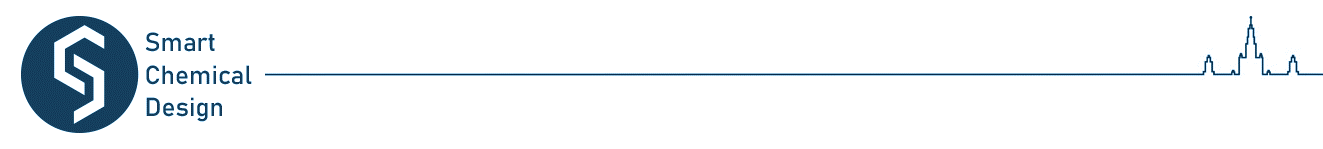

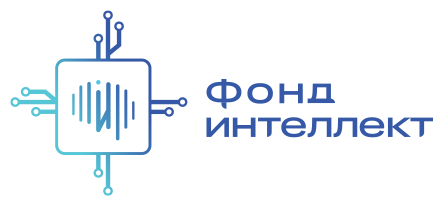

<h1>Построение QSPR моделей, предсказывающих свойства органических молекул</h1>
Этот практикум посвящен изучению процессу тренировки QSAR моделей машинного обучения для малых органических молекул. Будет рассмотрен весь процесс от работы с набором данных об активности молекул по отношению к hERG гену до модификации гиперпараметров модели для получения наилучшего результата.
<h2>Полезные ссылки</h2>
<ul>
<li>https://www.rdkit.org/docs/GettingStartedInPython.html</li>
<li>https://scikit-learn.org/stable/getting_started.html</li>
<li>https://scikit-learn.org/stable/modules/model_evaluation.html</li>
</ul>

Датасет: herg.sdf

Что нужно сделать?
Нужно провести полный процесс тренировки модели, включающий работу с датасетом (очистка, векторизация, разбиение), выбор оптимального алгоритма обучения (критерии могут разниться), ручную настройку гиперпараметров.

На выходе должна быть получена классификационная модель, характеризующая активность молекулы по отношению к гену hERG. Качество модели необходимо подтвердить несколькими метриками качества бинарной классификаци на заданном разбиении набора данных на тренировочный и тестовый


# Практикум


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit.Chem import MACCSkeys, AllChem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit import Chem

from sklearn.metrics import f1_score, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Преобразование данных

In [ ]:
# Загрузка датасета
mols = Chem.SDMolSupplier("/content/drive/MyDrive/herg.sdf") # На выходе array-like объект с молекулами в виде Mol объектов из rdkit

# Проверим общий размер
print(len(mols))

# Попробуем прочитать желаемое свойство и убедимся, что оно задано для всех молекул
# Используем конструкцию try/except, чтобы выбросить молекулы, для которых могут возникнуть ошибки
activities = []
clean_mols = []
for mol in mols:
    try:
        activities.append(mol.GetProp("herg_activity"))
        clean_mols.append(mol)
    except Exception:
        continue
print(len(activities))
print(len(clean_mols))

8154
8153
8153


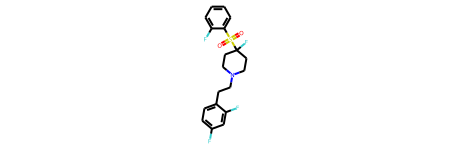

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True 

mols[45]

Посмотрим на распределение по классам

In [ ]:
mols_smiles = pd.read_csv("/content/drive/MyDrive/herg.csv")
ax = sns.countplot(x='activity', data=mols_smiles, palette="pastel")
total = float(len(mols_smiles))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()*0.6
    y = p.get_height()
    ax.annotate(percentage, (x, y),xytext=(0, 1),textcoords='offset points',ha='right',fontsize=12)

Классы несбалансированы

In [ ]:
len(mols_smiles['smiles'].unique())
scale_pos_weight = len(mols_smiles[mols_smiles['activity'] == 0]) / len(mols_smiles[mols_smiles['activity'] == 1])

In [ ]:
# Попробуем сформировать массивы 'X' и 'y':
# X - матрица, где каждой строчке будет соответствовать вектор из выбранных вами дескрипторов
# y - столбец со значениями активностей
# N.B. Убедитесь, что в тех случаях, когда не могут быть рассчитаны дескрипторы, вы не забыли исключить из дальнейшего рассмотрения соотвествующую активность
# E.g. можно использовать следующий или похожий код:

X = []
y = []

for i in range(len(clean_mols)):
    try:
        arr = np.zeros((1,), dtype=int)
        descr = AllChem.GetHashedAtomPairFingerprint(clean_mols[i])
        DataStructs.ConvertToNumpyArray(descr, arr)
        X.append(arr) 
        y.append(int(activities[i]))
    except Exception:
        continue

In [ ]:
X_np = np.stack(X, axis=0)
y_np = np.array(y)
X_np

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
fps = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048) for mol in clean_mols]

# Обучение

In [ ]:
X_Avalon = []
X_Hashed = []
X_MACCSKeys = []
y = []

for i in range(len(clean_mols)):
    try:
        arr = np.zeros((1,), dtype=int)
        descr = GetAvalonFP(clean_mols[i])
        DataStructs.ConvertToNumpyArray(descr, arr)
        X_Avalon.append(arr)

        arr = np.zeros((1,), dtype=int)
        descr = AllChem.GetHashedAtomPairFingerprint(clean_mols[i])
        DataStructs.ConvertToNumpyArray(descr, arr)
        X_Hashed.append(arr)

        arr = np.zeros((1,), dtype=int)
        descr = AllChem.GetMACCSKeysFingerprint(clean_mols[i])
        DataStructs.ConvertToNumpyArray(descr, arr)
        X_MACCSKeys.append(arr)

        y.append(int(activities[i]))
    except Exception:
        continue

In [ ]:
X_Avalon = np.stack(X_Avalon, axis=0)
X_Hashed = np.stack(X_Hashed, axis=0)
X_MACCSKeys = np.stack(X_MACCSKeys, axis=0)

y_np = np.array(y)

X_train_Avalon, X_test_Avalon, y_train_Avalon, y_test_Avalon = train_test_split(X_Avalon, y_np, test_size=0.2, random_state=42)
X_train_Hashed, X_test_Hashed, y_train_Hashed, y_test_Hashed = train_test_split(X_Hashed, y_np, test_size=0.2, random_state=42)
X_train_MACCSKeys, X_test_MACCSKeys, y_train_MACCSKeys, y_test_MACCSKeys = train_test_split(X_MACCSKeys, y_np, test_size=0.2, random_state=42)

Пробуем разные модели с разными дексрипторами

**GaussianNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB, ComplementNB
model = GaussianNB()

print(model)
model.fit(X_train_Avalon, y_train_Avalon)
print("GetAvalonFP: accuracy_score = ",  accuracy_score(y_test_Avalon, model.predict(X_test_Avalon)))
# print("GetAvalonFP: f1_score = ",  f1_score(y_test_Avalon, model.predict(X_test_Avalon)))

model.fit(X_train_Hashed, y_train_Hashed)
print("GetHashedAtomPairFingerprint: accuracy_score = ",  accuracy_score(y_test_Hashed, model.predict(X_test_Hashed)))

model.fit(X_train_MACCSKeys, y_train_MACCSKeys)
print("GetMACCSKeysFingerprint: accuracy_score = ",  accuracy_score(y_test_MACCSKeys, model.predict(X_test_MACCSKeys)))

GaussianNB()
GetAvalonFP: accuracy_score =  0.630901287553648
GetHashedAtomPairFingerprint: accuracy_score =  0.43041079092581236
GetMACCSKeysFingerprint: accuracy_score =  0.4727161250766401


**ComplementNB**  
Разновидность байесовского классификатора, используется при несбалансированных данных

In [ ]:
model = ComplementNB()

print(model)
model.fit(X_train_Avalon, y_train_Avalon)
print("GetAvalonFP: accuracy_score = ",  accuracy_score(y_test_Avalon, model.predict(X_test_Avalon)))

model.fit(X_train_Hashed, y_train_Hashed)
print("GetHashedAtomPairFingerprint: accuracy_score = ",  accuracy_score(y_test_Hashed, model.predict(X_test_Hashed)))

model.fit(X_train_MACCSKeys, y_train_MACCSKeys)
print("GetMACCSKeysFingerprint: accuracy_score = ",  accuracy_score(y_test_MACCSKeys, model.predict(X_test_MACCSKeys)))

ComplementNB()
GetAvalonFP: accuracy_score =  0.7375843041079092
GetHashedAtomPairFingerprint: accuracy_score =  0.7222562844880441
GetMACCSKeysFingerprint: accuracy_score =  0.6891477621091355


**RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

print(model)
model.fit(X_train_Avalon, y_train_Avalon)
print("GetAvalonFP: accuracy_score = ",  accuracy_score(y_test_Avalon, model.predict(X_test_Avalon)))

model.fit(X_train_Hashed, y_train_Hashed)
print("GetHashedAtomPairFingerprint: accuracy_score = ",  accuracy_score(y_test_Hashed, model.predict(X_test_Hashed)))

model.fit(X_train_MACCSKeys, y_train_MACCSKeys)
print("GetMACCSKeysFingerprint: accuracy_score = ",  accuracy_score(y_test_MACCSKeys, model.predict(X_test_MACCSKeys)))


RandomForestClassifier()
GetAvalonFP: accuracy_score =  0.8920907418761496
GetHashedAtomPairFingerprint: accuracy_score =  0.9006744328632741
GetMACCSKeysFingerprint: accuracy_score =  0.8847332924586143


**BaggingClassifier**

In [ ]:
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier()

print(model)
model.fit(X_train_Avalon, y_train_Avalon)
print("GetAvalonFP: accuracy_score = ",  accuracy_score(y_test_Avalon, model.predict(X_test_Avalon)))

model.fit(X_train_Hashed, y_train_Hashed)
print("GetHashedAtomPairFingerprint: accuracy_score = ",  accuracy_score(y_test_Hashed, model.predict(X_test_Hashed)))

model.fit(X_train_MACCSKeys, y_train_MACCSKeys)
print("GetMACCSKeysFingerprint: accuracy_score = ",  accuracy_score(y_test_MACCSKeys, model.predict(X_test_MACCSKeys)))

BaggingClassifier()
GetAvalonFP: accuracy_score =  0.874310239117106
GetHashedAtomPairFingerprint: accuracy_score =  0.8810545677498467
GetMACCSKeysFingerprint: accuracy_score =  0.8779889638258737


In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()

print(model)
model.fit(X_train_Avalon, y_train_Avalon)
print("GetAvalonFP: accuracy_score = ",  accuracy_score(y_test_Avalon, model.predict(X_test_Avalon)))

model.fit(X_train_Hashed, y_train_Hashed)
print("GetHashedAtomPairFingerprint: accuracy_score = ",  accuracy_score(y_test_Hashed, model.predict(X_test_Hashed)))

model.fit(X_train_MACCSKeys, y_train_MACCSKeys)
print("GetMACCSKeysFingerprint: accuracy_score = ",  accuracy_score(y_test_MACCSKeys, model.predict(X_test_MACCSKeys)))

XGBClassifier()
GetAvalonFP: accuracy_score =  0.8614347026364194
GetHashedAtomPairFingerprint: accuracy_score =  0.8871857755977928
GetMACCSKeysFingerprint: accuracy_score =  0.8565297363580625


# Вариация параметров

Остановимся на **RandomForestClassifier**, будем варьировать параметры и смотреть на метрики
  

In [ ]:
X_train, X_test, y_train, y_test = X_train_Hashed, X_test_Hashed, y_train_Hashed, y_test_Hashed

In [ ]:
from sklearn.metrics import f1_score, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, matthews_corrcoef

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced_subsample')

model.fit(X_train, y_train)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

accuracy_score = 0.897608828939301
precision_score = 0.8828337874659401
recall_score = 0.7232142857142857
f1_score = 0.7950920245398774
matthews_corrcoef = 0.7341703499900085


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy")

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy')
accuracy_score = 0.9019006744328633
precision_score = 0.8956043956043956
recall_score = 0.7276785714285714
f1_score = 0.8029556650246306
matthews_corrcoef = 0.7456328103358879


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=50)

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=50)
accuracy_score = 0.8963825873697119
precision_score = 0.8864265927977839
recall_score = 0.7142857142857143
f1_score = 0.7911001236093943
matthews_corrcoef = 0.7307136530301478


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=200)

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=200)
accuracy_score = 0.9006744328632741
precision_score = 0.8864864864864865
recall_score = 0.7321428571428571
f1_score = 0.8019559902200489
matthews_corrcoef = 0.7424741162740889


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=500)

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=500)
accuracy_score = 0.8994481912936848
precision_score = 0.8922651933701657
recall_score = 0.7209821428571429
f1_score = 0.797530864197531
matthews_corrcoef = 0.7389996949557646


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=1000)

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=1000)
accuracy_score = 0.9012875536480687
precision_score = 0.8931506849315068
recall_score = 0.7276785714285714
f1_score = 0.8019680196801968
matthews_corrcoef = 0.7439994360880874


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=1500)

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=1500)
accuracy_score = 0.8994481912936848
precision_score = 0.8879781420765027
recall_score = 0.7254464285714286
f1_score = 0.7985257985257986
matthews_corrcoef = 0.7390789751934397


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=500, max_features='log2')

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_features='log2', n_estimators=500)
accuracy_score = 0.8957694665849172
precision_score = 0.8971428571428571
recall_score = 0.7008928571428571
f1_score = 0.7869674185463659
matthews_corrcoef = 0.7289484190951839


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=500, warm_start=True)

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:766: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  'class_weight presets "balanced" or '


RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=500, warm_start=True)
accuracy_score = 0.9037400367872471
precision_score = 0.8900804289544236
recall_score = 0.7410714285714286
f1_score = 0.8087697929354446
matthews_corrcoef = 0.7507508012457075


In [ ]:
model = RandomForestClassifier(criterion="entropy",n_estimators=500, warm_start=True)

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

RandomForestClassifier(criterion='entropy', n_estimators=500, warm_start=True)
accuracy_score = 0.8988350705088902
precision_score = 0.8985915492957747
recall_score = 0.7120535714285714
f1_score = 0.7945205479452054
matthews_corrcoef = 0.7372856149297022


In [ ]:
model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=500, warm_start=True)

model.fit(X_train, y_train)
print(model)
print("accuracy_score =",  accuracy_score(y_test, model.predict(X_test)))
print("precision_score =",  precision_score(y_test, model.predict(X_test)))
print("recall_score =",  recall_score(y_test, model.predict(X_test)))
print("f1_score =",  f1_score(y_test, model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, model.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:766: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  'class_weight presets "balanced" or '


RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       n_estimators=500, warm_start=True)
accuracy_score = 0.9031269160024524
precision_score = 0.8897849462365591
recall_score = 0.7388392857142857
f1_score = 0.8073170731707316
matthews_corrcoef = 0.7490861014627187


In [ ]:
cf_matrix = confusion_matrix(y_test, model.predict(X_test))

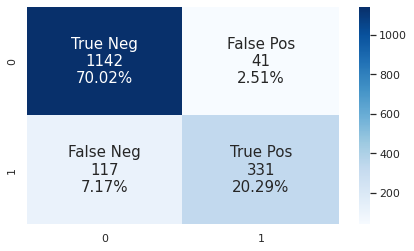

In [ ]:
sns.set(rc={'figure.figsize':(7,4)})
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',annot_kws={"size": 15})
None

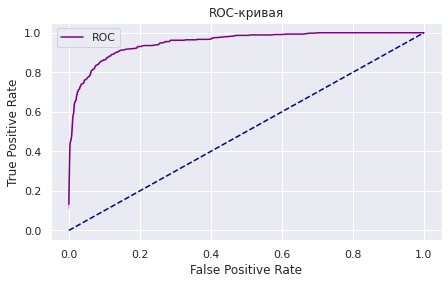

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, prob)

sns.lineplot(x=fpr, y=tpr, color='purple', label='ROC')
sns.lineplot(x=[0, 1], y=[0, 1], color='darkblue', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()
